In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
xy_data_Path = "xy_data_rand.csv" #Paths Different for Everyone
xy_data = pd.read_csv(xy_data_Path)

In [4]:
abc_data_Path = "abc_data_rand.csv" #Paths Different for Everyone
abc_data = pd.read_csv(abc_data_Path)

In [5]:
all_data=pd.DataFrame.join(xy_data,abc_data)

In [6]:
training_data, validation_data = train_test_split(all_data, test_size=0.2, random_state=42)

In [54]:
X_traine = training_data.iloc[:,0:500]
y_traine = training_data.iloc[:,500:504]

X_vale = validation_data.iloc[:,0:500]
y_vale = validation_data.iloc[:,500:504]

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_traine)
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_traine.to_numpy(), dtype=torch.float32)

X_val_scaled = scaler.transform(X_vale)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_vale.to_numpy(), dtype=torch.float32)

In [67]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

valset = TensorDataset(X_val, y_val)
val_loader = DataLoader(valset, batch_size=64, shuffle=True)

In [68]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out



In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 500  # Number of y-coordinates
hidden_size1 = 128
hidden_size2 = 64
output_size = 4   # Number of coefficients
model = FeedforwardNN(input_size, hidden_size1,hidden_size2, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000005, weight_decay = 1e-5)

In [70]:
# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
model.apply(weights_init)

FeedforwardNN(
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [71]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    return val_loss / len(val_loader.dataset)

In [72]:
def coefficient_error(guess, real):
    error = np.abs(np.array(guess)/np.array(real)-1)*100
    return error

def accuracy_check(inputs, targets, model, batch_size = 64):
    model.eval()
    error = []
    with torch.no_grad():  # Turn off gradients since we're in inference mode
        inputs = pd.DataFrame(inputs.numpy())
        targets = pd.DataFrame(targets.numpy())
        for i in range(0,batch_size):
            input = inputs.iloc[i,:]
            target = targets.iloc[i,:]
            test_tensor = torch.tensor(input.to_numpy(), dtype=torch.float32 )
            preds = model(test_tensor)
            predicted_labels = preds.detach().numpy()
            target = target.to_numpy()
            error_trial = coefficient_error(predicted_labels,target)
            error.append(error_trial.tolist())
                
        total_error = np.abs(np.sum(np.sum(error,axis=0)/batch_size)/4)
        
        return total_error
    
    

In [78]:
num_epochs = 100
val_loss_data = []
training_loss_data = []
batch_acc = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    val_loss = validate_model(model, val_loader, criterion, device)
    acc = accuracy_check(inputs, targets, model)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}; Val loss = {val_loss}; Batch error = {acc}%')
    val_loss_data.append(val_loss)
    training_loss_data.append(loss.item())
    batch_acc.append(acc)
    

Epoch [1/100], Loss: 0.0045; Val loss = 0.0029209224451333285; Batch error = 0.6010461496189237%
Epoch [2/100], Loss: 0.0030; Val loss = 0.002847892849287018; Batch error = 0.6525716716423631%
Epoch [3/100], Loss: 0.0019; Val loss = 0.002781892517581582; Batch error = 0.5861759465187788%
Epoch [4/100], Loss: 0.0058; Val loss = 0.00274655745010823; Batch error = 0.8674905905500054%
Epoch [5/100], Loss: 0.0022; Val loss = 0.0026762290658429266; Batch error = 0.9674585731700063%
Epoch [6/100], Loss: 0.0025; Val loss = 0.002611047566495836; Batch error = 0.6986445505172014%
Epoch [7/100], Loss: 0.0030; Val loss = 0.0025821588560938835; Batch error = 0.838316060602665%
Epoch [8/100], Loss: 0.0009; Val loss = 0.002514492685254663; Batch error = 0.3311564717441797%
Epoch [9/100], Loss: 0.0015; Val loss = 0.0024647152373567225; Batch error = 0.650114200077951%
Epoch [10/100], Loss: 0.0022; Val loss = 0.002405117088742554; Batch error = 0.7620570454746485%
Epoch [11/100], Loss: 0.0020; Val loss

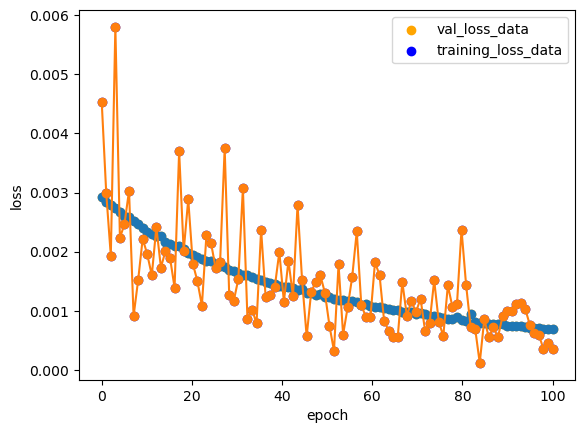

In [79]:
data = val_loss_data
data2 = training_loss_data
x = np.linspace(0,100, 100)
plt.scatter(x, data, color='orange', label='val_loss_data')
plt.plot(x, data, '-o')
plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.plot(x, data2, '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.close()

TypeError: 'Axes' object is not subscriptable

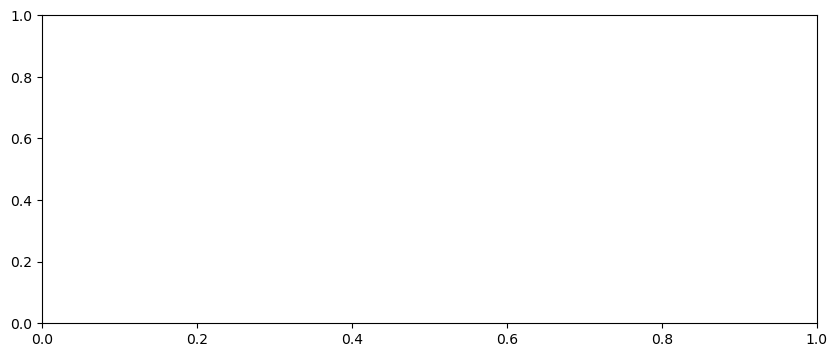

In [26]:
x = np.linspace(0,num_epochs, num_epochs)
def plotabc(x, data,data2, name,ax):
    ax.scatter(x, data, color='blue', label='Data Points')
    ax.plot(x, data, '-o')
    ax.scatter(x, data2, color='red', label='Data Points')
    ax.plot(x, data2, '-o')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(f'{name} ')
    ax.legend()
    # print(slope)
    # print(intercept)
    


_, axs = plt.subplots(1, 1, figsize=(10, 4))
plotabc(x, val_loss_data,training_loss_data, 'validation loss',axs[0])
#plotabc(x, training_loss_data, 'Training loss',axs[1])
#plotabc(x, batch_acc, 'inaccurate % per batch',axs[2])

plt.tight_layout()


In [92]:
num_trials = 1
x = np.linspace(-50,50,500)
y = []
coefficients = []
print(np.shape(x))


a = np.random.uniform(-25,25,num_trials)
b = np.random.uniform(-25,25,num_trials)
c = np.random.uniform(-25,25,num_trials)
d = np.random.uniform(-25,25,num_trials)


y_trial = 0
for i in range(num_trials):
    a_trial = a[i]
    b_trial = b[i]
    c_trial = c[i]
    d_trial = d[i]
    y_trial = a_trial * x ** 3 + b_trial * x ** 2 + c_trial * x + d_trial
    y.append(y_trial)
    coefficients.append([a_trial, b_trial, c_trial, d_trial])


xydf = pd.concat([pd.DataFrame(x.reshape(1,-1)),pd.DataFrame(y)])
abcdf = pd.DataFrame(coefficients)


xydfnp = xydf.iloc[1,:].to_numpy()
xydfnp = np.expand_dims(xydfnp, axis=1)
print(xydfnp.shape)
test_tensor = torch.tensor(xydfnp, dtype=torch.float32)
print(abcdf)

(500,)
(500, 1)
           0          1         2         3
0 -23.722154 -19.871345  6.648778  2.875189


In [93]:

model.eval()
with torch.no_grad():  # Turn off gradients since we're in inference mode
    
    test_tensor = test_tensor.view(1, -1)
    test_tensor_scaled = scaler.transform(test_tensor)
    outputs = model(torch.tensor(test_tensor_scaled, dtype=torch.float32))
    
predicted_labels = outputs.detach().numpy()  # Convert to numpy 
print("Predicted Output:", predicted_labels)

Predicted Output: [[-23.723434  -19.87841     6.6418576   2.8827066]]


c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [94]:
true_values = abcdf.iloc[0,:].to_numpy()
predicted_labels = predicted_labels.flatten()

In [95]:
x = np.linspace(-100, 100, 2000)
y_true = true_values[0]*x**3+true_values[1]*x**2+true_values[2]*x+true_values[3]
y_predicted = predicted_labels[0]*x**3+predicted_labels[1]*x**2+predicted_labels[2]*x+predicted_labels[3]

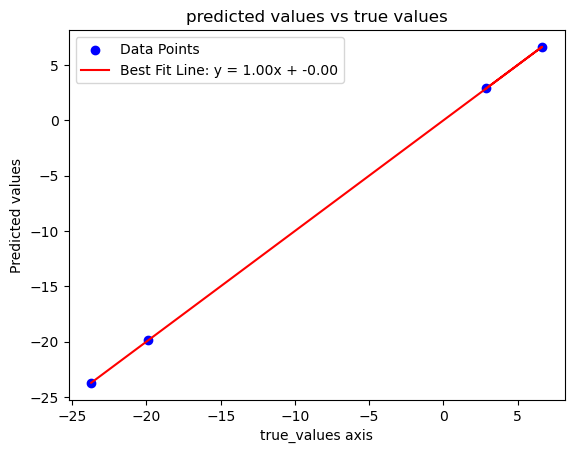

1.0001116626126447
-0.0009859726275029956


<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

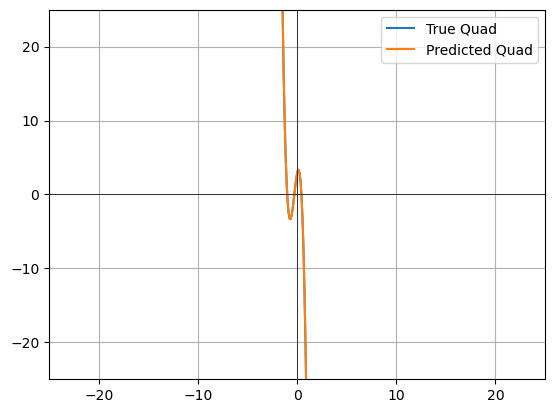

In [96]:
#per single sample plots

slope, intercept =  np.polyfit(true_values, predicted_labels, 1)
line = slope * true_values + intercept

plt.scatter(true_values, predicted_labels, color='blue', label='Data Points')
plt.plot(true_values, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('true_values axis')
plt.ylabel('Predicted values')
plt.title('predicted values vs true values')
plt.legend()
plt.show()
print(slope)
print(intercept)
plt.close

plt.plot(x, y_true, label='True Quad')
plt.plot(x, y_predicted, label='Predicted Quad')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid()
plt.legend()
plt.close

In [85]:
num_trials = 10000
x = np.linspace(-50,50,500)
y = []
coefficients = []
print(np.shape(x))

np.random.seed(21)

a = np.random.uniform(-25,25,num_trials)
b = np.random.uniform(-25,25,num_trials)
c = np.random.uniform(-25,25,num_trials)
d = np.random.uniform(-25,25,num_trials)


y_trial = 0
for i in range(num_trials):
    a_trial = a[i]
    b_trial = b[i]
    c_trial = c[i]
    d_trial = d[i]
    y_trial = a_trial * x ** 3 + b_trial * x ** 2 + c_trial * x + d_trial
    y.append(y_trial)
    coefficients.append([a_trial, b_trial, c_trial, d_trial])


xydf = pd.concat([pd.DataFrame(x.reshape(1,-1)),pd.DataFrame(y)])
abcdf = pd.DataFrame(coefficients)


xydfnp = xydf.iloc[1,:].to_numpy()
xydfnp = np.expand_dims(xydfnp, axis=1)
print(xydfnp.shape)


(500,)
(500, 1)


In [86]:
a_real, a_guess,b_real, b_guess, c_real, c_guess,d_real, d_guess  = [], [], [], [], [], [], [], []


for i in range(0,num_trials):


    xydfnpslice = xydf.iloc[i+1,:].to_numpy()
    xydfnpslice = np.expand_dims(xydfnpslice, axis=1)
    test_tensor_slice = torch.tensor(xydfnpslice, dtype=torch.float32)

    model.eval()
    with torch.no_grad():  # Turn off gradients since we're in inference mode
    
        test_tensor_slice = test_tensor_slice.view(1, -1)
        test_tensor_slice_scaled = scaler.transform(test_tensor_slice)
        outputs = model(torch.tensor(test_tensor_slice_scaled, dtype=torch.float32))
        predicted_labels = outputs.detach().numpy()  # Convert to numpy 
    
    a_real.append(abcdf.iloc[i,:].to_numpy().flatten()[0])
    a_guess.append(predicted_labels.flatten()[0])
    b_real.append(abcdf.iloc[i,:].to_numpy().flatten()[1])
    b_guess.append(predicted_labels.flatten()[1])
    c_real.append(abcdf.iloc[i,:].to_numpy().flatten()[2])
    c_guess.append(predicted_labels.flatten()[2]) 
    d_real.append(abcdf.iloc[i,:].to_numpy().flatten()[3])
    d_guess.append(predicted_labels.flatten()[3])     

#THIS SPEWS A BUNCH OF ERRORS BUT DON'T WORRY ABOUT IT

c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Matth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid f

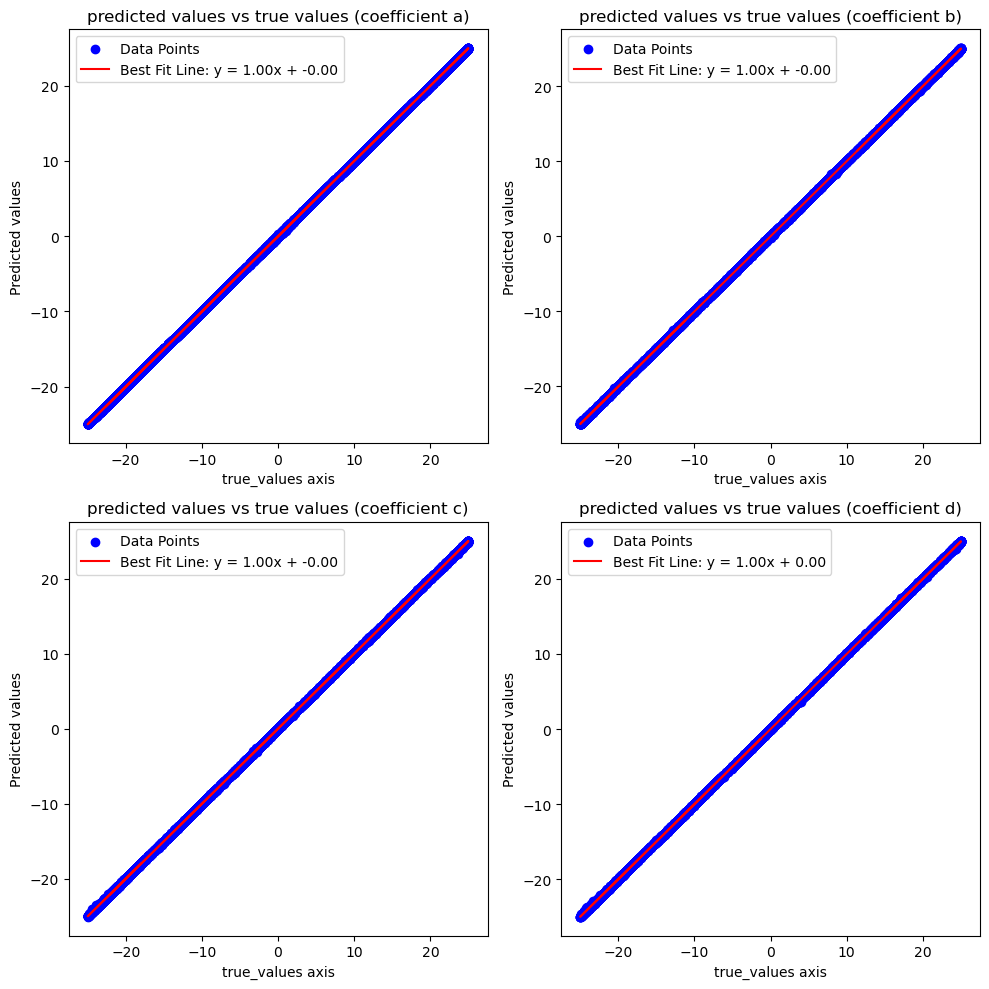

In [87]:
def plotabc(real, guess, name,ax):
    slope, intercept =  np.polyfit(real, guess, 1)
    line = slope * np.array(real) + intercept
    ax.scatter(real, guess, color='blue', label='Data Points')
    ax.plot(real, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
    ax.set_xlabel('true_values axis')
    ax.set_ylabel('Predicted values')
    ax.set_title(f'predicted values vs true values (coefficient {name})')
    ax.legend()
    # print(slope)
    # print(intercept)
    


_, axs = plt.subplots(2, 2, figsize=(10, 10))
plotabc(a_real, a_guess, 'a',axs[0,0])
plotabc(b_real, b_guess, 'b',axs[0,1])
plotabc(c_real, c_guess, 'c',axs[1,0])
plotabc(d_real, d_guess, 'd',axs[1,1])
plt.tight_layout()

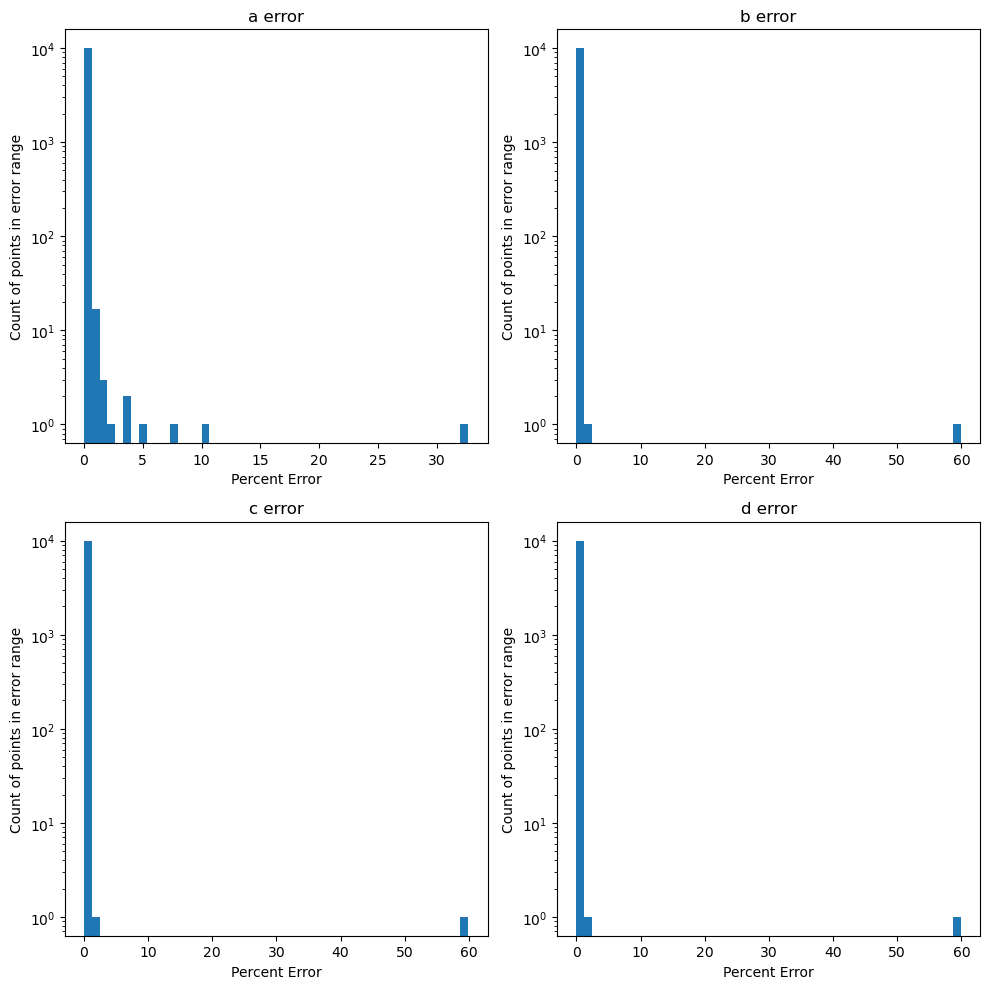

In [88]:
def coefficient_error(guess, real):
    error = np.abs(np.array(guess)/np.array(real)-1)
    return error


a_error = (coefficient_error(a_guess, a_real)).tolist()
b_error = (coefficient_error(b_guess, b_real)).tolist()
c_error = (coefficient_error(c_guess, c_real)).tolist()
d_error = (coefficient_error(d_guess, d_real)).tolist()

def plot_hist(errors, title, ax):
    bins = np.linspace(0, max(errors), 50)
    ax.hist(errors, bins=bins, log=True)
    ax.set_title(title)
    ax.set_xlabel('Percent Error')
    ax.set_ylabel('Count of points in error range')  

_, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_hist(a_error, 'a error', axs[0,0])
plot_hist(b_error, 'b error', axs[0,1])
plot_hist(b_error, 'c error', axs[1,0])
plot_hist(b_error, 'd error', axs[1,1])
plt.tight_layout()

#plt.show()